# Capstone Project-6  (Titanic Prediction) AdaBoosting, GradientBoosting, XGBoosting

**Overview**

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

**The training set** should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

(Eğitim seti, makine öğrenimi modellerinizi oluşturmak için kullanılmalıdır. Eğitim seti için, her yolcu için sonucu "temel gerçek" olarak da bilinir) sağlarız. Modeliniz, yolcuların cinsiyeti ve sınıfı gibi “özellikler”e dayalı olacaktır. Yeni özellikler oluşturmak için özellik mühendisliğini de kullanabilirsiniz.)

**The test set** should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

(**Test seti**, modelinizin görünmeyen veriler üzerinde ne kadar iyi performans gösterdiğini görmek için kullanılmalıdır. Test seti için, her yolcu için temel gerçeği sağlamıyoruz. Bu sonuçları tahmin etmek sizin işiniz. Test setindeki her yolcu için, eğittiğiniz modeli kullanarak Titanik'in batmasından sağ çıkıp çıkmadıklarını tahmin edin.)

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

Ayrıca, bir gönderim dosyasının nasıl görünmesi gerektiğine örnek olarak, tüm ve yalnızca kadın yolcuların hayatta kaldığını varsayan bir dizi tahmin olan cinsiyet_submission.csv'yi de dahil ediyoruz.

**Data Dictionary**

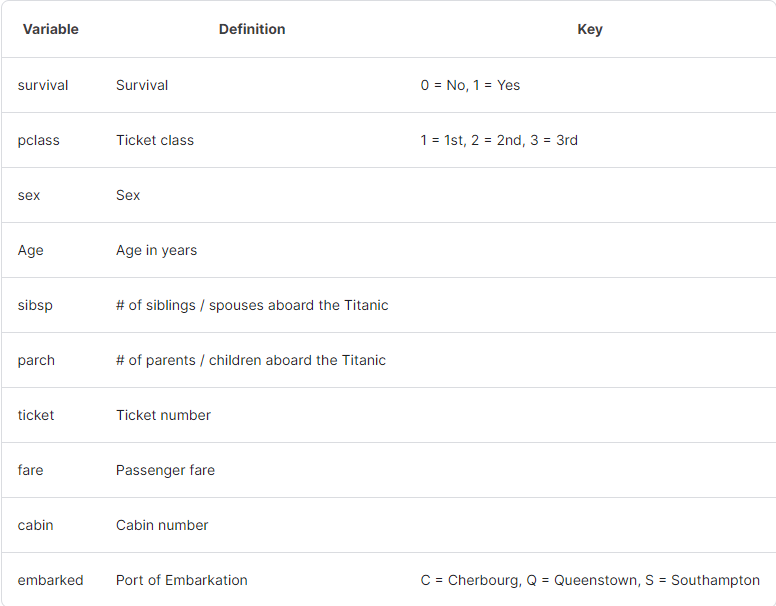

**Variable Notes**

pclass: A proxy for socio-economic status (SES)

1st = Upper

2nd = Middle

3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import cufflinks as cf

from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()


%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_auc_score, auc
from sklearn.metrics import roc_curve, average_precision_score, precision_recall_curve
from sklearn.preprocessing import  LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")


In [2]:
sns.__version__

'0.12.2'

In [3]:
df_train = pd.read_csv("train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

summary(df_train)

Data shape: (891, 12)
___________________________
Data Types:
object     5
int64      5
float64    2
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
Age,float64,714,89,177,0.42,80.0
Cabin,object,204,148,687,NaN,NaN
Embarked,object,889,4,2,NaN,NaN
Fare,float64,891,248,0,0.0,512.3292
Name,object,891,891,0,"Abbing, Mr. Anthony","van Melkebeke, Mr. Philemon"
Parch,int64,891,7,0,0,6
PassengerId,int64,891,891,0,1,891
Pclass,int64,891,3,0,1,3
Sex,object,891,2,0,female,male
SibSp,int64,891,7,0,0,8


In [5]:
def duplicate_values(df):
    print("Duplicate check...")
    num_duplicates = df.duplicated(subset=None, keep='first').sum()
    if num_duplicates > 0:
        print("There are", num_duplicates, "duplicated observations in the dataset.")
        df.drop_duplicates(keep='first', inplace=True)
        print(num_duplicates, "duplicates were dropped!")
        print('*' * 100)
    else:
        print("There are no duplicated observations in the dataset.")

In [6]:
df_train_1 = df_train.copy()

In [7]:
#df_train_1.set_index('PassengerId', inplace=True)


In [8]:
df_train_1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df_test = pd.read_csv("test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [10]:
summary(df_test)

Data shape: (418, 11)
___________________________
Data Types:
object     5
int64      4
float64    2
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
Age,float64,332,80,86,0.17,76.0
Cabin,object,91,77,327,NaN,NaN
Embarked,object,418,3,0,C,S
Fare,float64,417,170,1,0.0,512.3292
Name,object,418,418,0,"Abbott, Master. Eugene Joseph","van Billiard, Master. Walter John"
Parch,int64,418,8,0,0,9
PassengerId,int64,418,418,0,892,1309
Pclass,int64,418,3,0,1,3
Sex,object,418,2,0,female,male
SibSp,int64,418,7,0,0,8


In [11]:
df_test_1 = df_test.copy()

In [12]:
#df_test_1.set_index('PassengerId', inplace=True)
df_test_1.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [143]:
df_gender_sub = pd.read_csv("gender_submission.csv")
df_gender_sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [144]:
df_gender_sub.shape

(418, 2)

In [140]:
#df_gender_sub.drop(columns=["PassengerId"], inplace=True)


KeyError: "['PassengerId'] not found in axis"

In [145]:
summary(df_gender_sub)

Data shape: (418, 2)
___________________________
Data Types:
int64    2
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
PassengerId,int64,418,418,0,892,1309
Survived,int64,418,2,0,0,1


In [13]:
duplicate_values(df_train_1)

Duplicate check...
There are no duplicated observations in the dataset.


In [14]:
duplicate_values(df_test_1)

Duplicate check...
There are no duplicated observations in the dataset.


# Exploratory Data Analysis and Visualization

In [15]:
df_train_1.shape

(891, 12)

In [16]:
df_train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [17]:
df_train_1.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [18]:
df_test_1.shape

(418, 11)

In [19]:
df_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [20]:
df_test_1.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [21]:
df_train_1.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [22]:
df_test_1.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,418.0,1100.500000,120.810458,892.00,996.2500,1100.5000,1204.75,1309.0000
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.00,3.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.00,76.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.00,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.00,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.50,512.3292


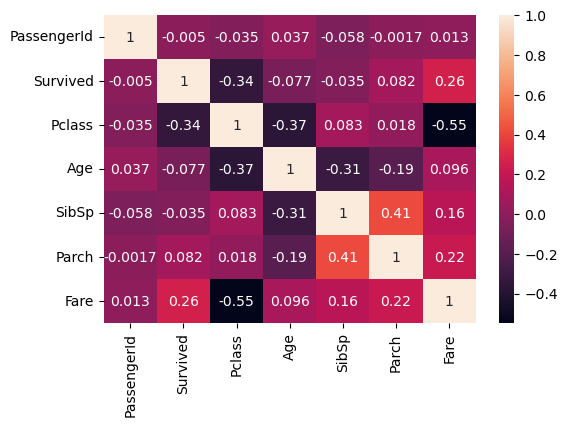

In [23]:
sns.heatmap(df_train_1.corr(),annot=True);

## Columns : Add - Drop - Index 

In [24]:
df_train_1.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [25]:
#df_train_1.drop(columns=['Ticket','Cabin','Embarked'],inplace=True)

In [26]:
df_train_1 = df_train_1.iloc[:, [0,3,6,7,8,9,10,11, 4,5,2,1]] 

In [27]:
df_train_1.head(1)

,PassengerId,Name,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex,Age,Pclass,Survived
0,1,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.25,NaN,S,male,22.0,3,0


In [28]:
df_test_1.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [29]:
#df_test_1.drop(columns=['Ticket','Cabin','Embarked'],inplace=True)


In [30]:
df_test_1 = df_test_1.iloc[:, [0,2,5,6,7,8,9,10,3,4,1]] 

In [31]:
df_test_1.head(1)

,PassengerId,Name,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex,Age,Pclass
0,892,"Kelly, Mr. James",0,0,330911,7.8292,NaN,Q,male,34.5,3


## Missing Value Control 

In [32]:
def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending = False)
    missing_percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending = False)
    missing_values = pd.concat([missing_number, missing_percent], axis = 1, keys = ['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number'] > 0]

In [33]:
missing_values(df_train_1)

,Missing_Number,Missing_Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


In [34]:
missing_values(df_test_1)

,Missing_Number,Missing_Percent
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392


In [35]:
df_test_1.head(1)

,PassengerId,Name,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex,Age,Pclass
0,892,"Kelly, Mr. James",0,0,330911,7.8292,NaN,Q,male,34.5,3


## Features 
### Names

In [36]:
df_train_1['Name'].value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

### SibSp

In [37]:
px.histogram(df_train_1, x='SibSp', color="Survived", barmode='group', title='Survived by Sex')

### Parch	

### Ticket

### Fare

### Cabin

### Embarked

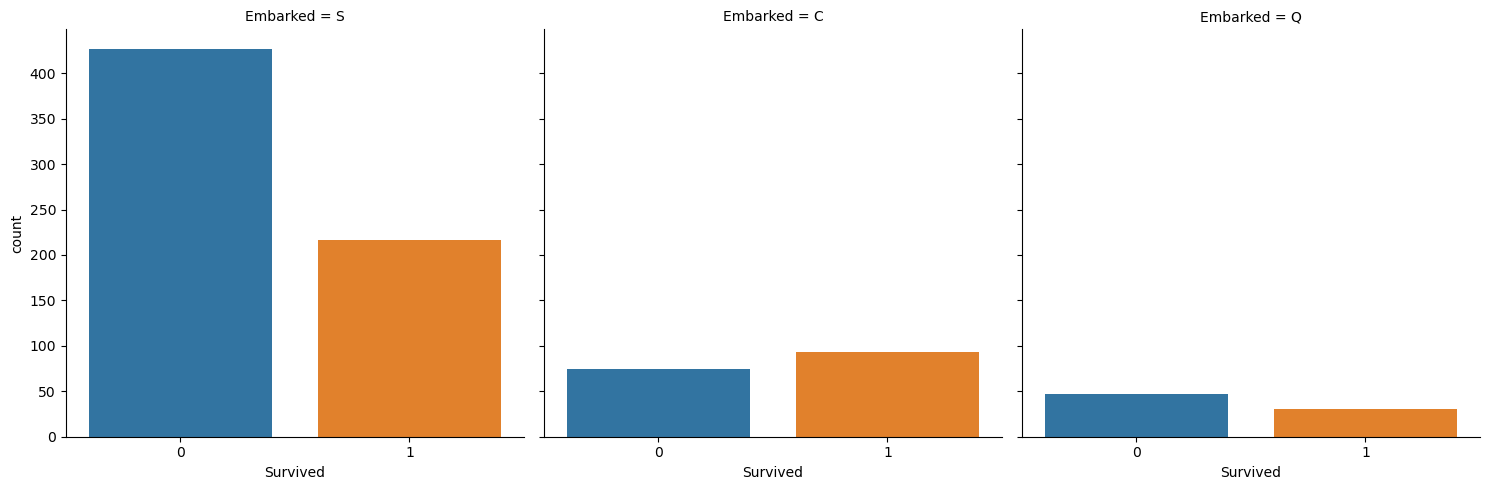

In [38]:
sns.catplot(x='Survived', col='Embarked', kind='count', data=df_train_1);

In [39]:
pd.crosstab([df_train_1.Survived], [df_train_1.Sex, df_train_1.Pclass, df_train_1.Embarked], margins=True)

Sex      female                              male                            \
Pclass        1         2          3            1          2          3       
Embarked      C  Q   S  C  Q   S   C   Q   S    C  Q   S   C  Q   S   C   Q   
Survived                                                                      
0             1  0   2  0  0   6   8   9  55   25  1  51   8  1  82  33  36   
1            42  1  46  7  2  61  15  24  33   17  0  28   2  0  15  10   3   
All          43  1  48  7  2  67  23  33  88   42  1  79  10  1  97  43  39   

Sex            All  
Pclass              
Embarked    S       
Survived            
0         231  549  
1          34  340  
All       265  889

### Sex

In [40]:
df_train_1.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

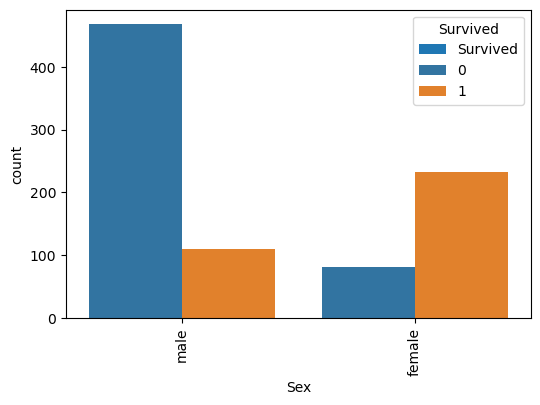

In [41]:
df_train_1[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()
sns.countplot(x='Sex',hue='Survived',data=df_train_1)
plt.show()

In [42]:
px.histogram(df_train_1, x='Sex', color="Survived", barmode='group', title='Survived by Sex')

### Age

In [43]:
px.histogram(df_train_1, x='Age', color="Survived", barmode='group', title='Survived by Age')

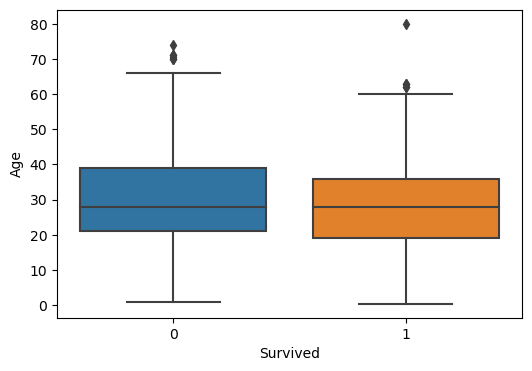

In [44]:
 sns.boxplot(data=df_train_1, y="Age",x='Survived');

### Pclass

In [45]:
df_train_1["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [46]:
px.histogram(df_train_1, x='Pclass', color="Survived", barmode='group', title='Survived by Pclass')

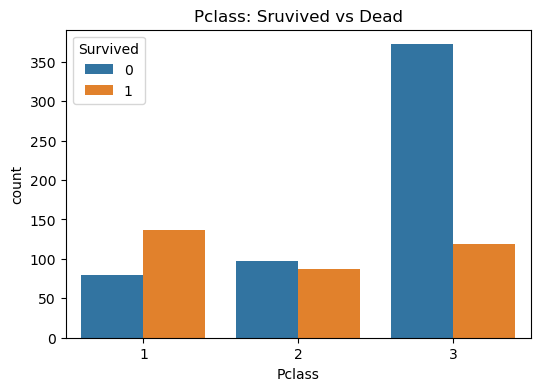

In [47]:
sns.countplot(x='Pclass', hue='Survived', data=df_train_1)
plt.title('Pclass: Sruvived vs Dead')
plt.show()

In [48]:
pd.crosstab([df_train_1.Sex,df_train_1.Survived],df_train_1.Pclass,margins=True).style.background_gradient(cmap='summer_r')

In [49]:
print("% of survivals in") 
print("Pclass=1 : ", df_train_1.Survived[df_train_1.Pclass == 1].sum()/df_train_1[df_train_1.Pclass == 1].Survived.count())
print("Pclass=2 : ", df_train_1.Survived[df_train_1.Pclass == 2].sum()/df_train_1[df_train_1.Pclass == 2].Survived.count())
print("Pclass=3 : ", df_train_1.Survived[df_train_1.Pclass == 3].sum()/df_train_1[df_train_1.Pclass == 3].Survived.count())

% of survivals in
Pclass=1 :  0.6296296296296297
Pclass=2 :  0.47282608695652173
Pclass=3 :  0.24236252545824846


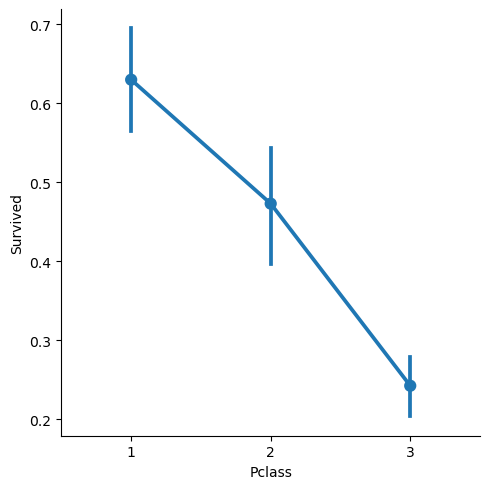

In [50]:
sns.catplot(x='Pclass',y='Survived', kind='point', data=df_train_1);

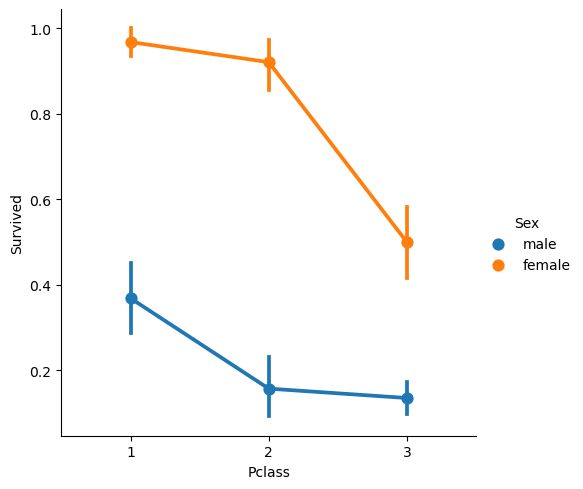

In [51]:
sns.catplot(x='Pclass',y='Survived',hue='Sex', kind='point', data=df_train_1);

### Survived

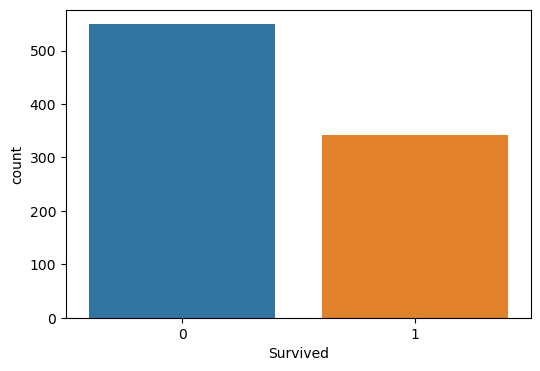

In [52]:
sns.countplot(x='Survived', data = df_train_1)
plt.show();

In [53]:
df_train_1["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Passenger Class and Sex 

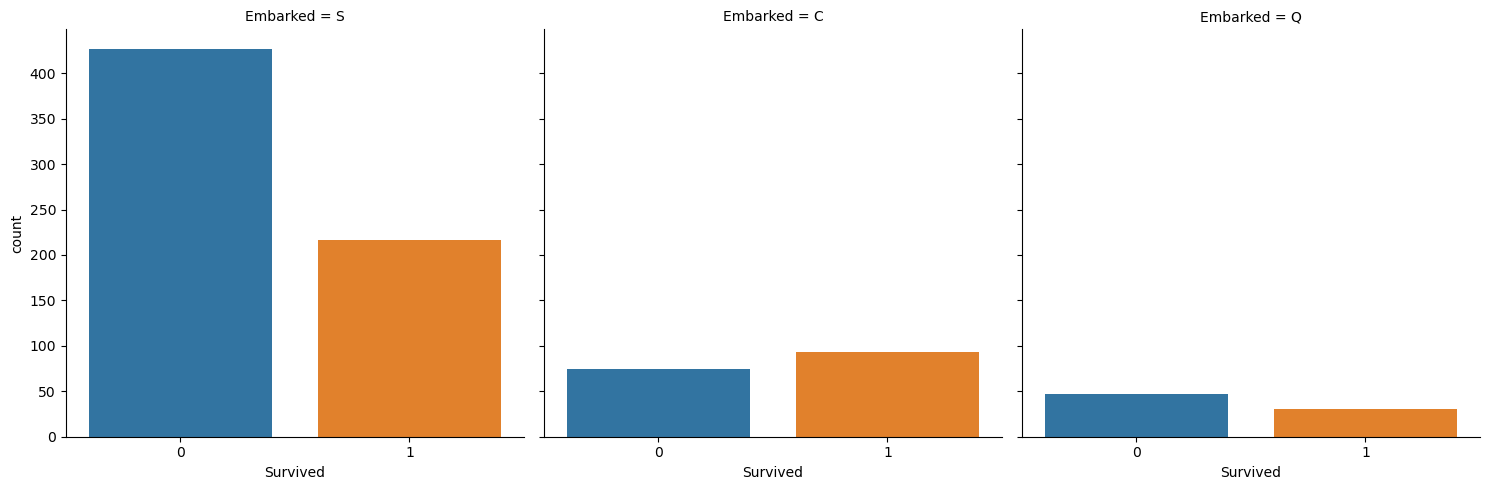

In [54]:
sns.catplot(x='Survived', col='Embarked', kind='count', data=df_train_1);

### Embarked : Survival rate lowest for S and highest for C

In [55]:
print("% of women survived: " , df_train_1[df_train_1.Sex == 'female'].Survived.sum()/df_train_1[df_train_1.Sex == 'female'].Survived.count())
print("% of men survived:   " , df_train_1[df_train_1.Sex == 'male'].Survived.sum()/df_train_1[df_train_1.Sex == 'male'].Survived.count())

% of women survived:  0.7420382165605095
% of men survived:    0.18890814558058924


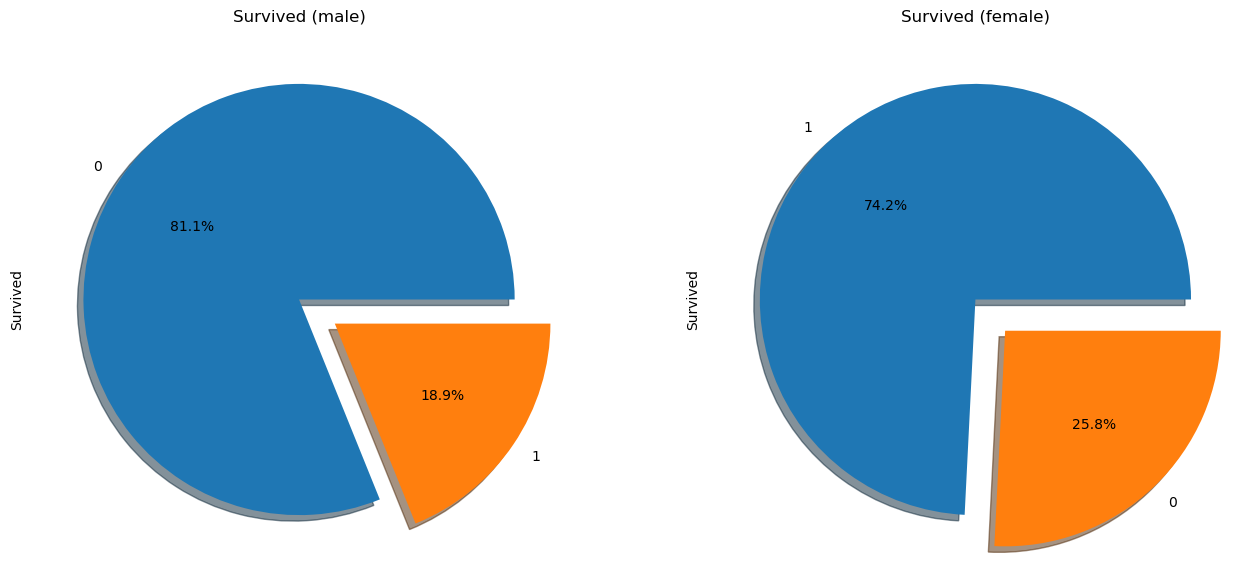

In [56]:
f,ax=plt.subplots(1,2,figsize=(16,7))
df_train_1['Survived'][df_train_1['Sex']=='male'].value_counts().plot.pie(explode=[0,0.2],autopct='%1.1f%%',ax=ax[0],shadow=True)
df_train_1['Survived'][df_train_1['Sex']=='female'].value_counts().plot.pie(explode=[0,0.2],autopct='%1.1f%%',ax=ax[1],shadow=True)
ax[0].set_title('Survived (male)')
ax[1].set_title('Survived (female)')

plt.show()

In [57]:
pd.crosstab(df_train.Pclass, df_train.Survived, margins=True).style.background_gradient(cmap='autumn_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


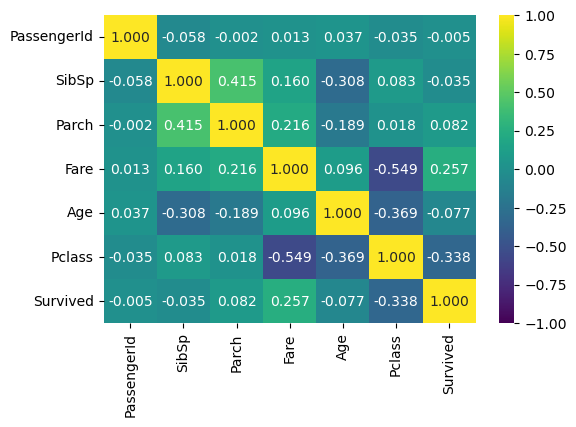

In [58]:
sns.heatmap(df_train_1.corr(),vmin=-1,vmax=1, annot=True, fmt='.3f', cmap='viridis');

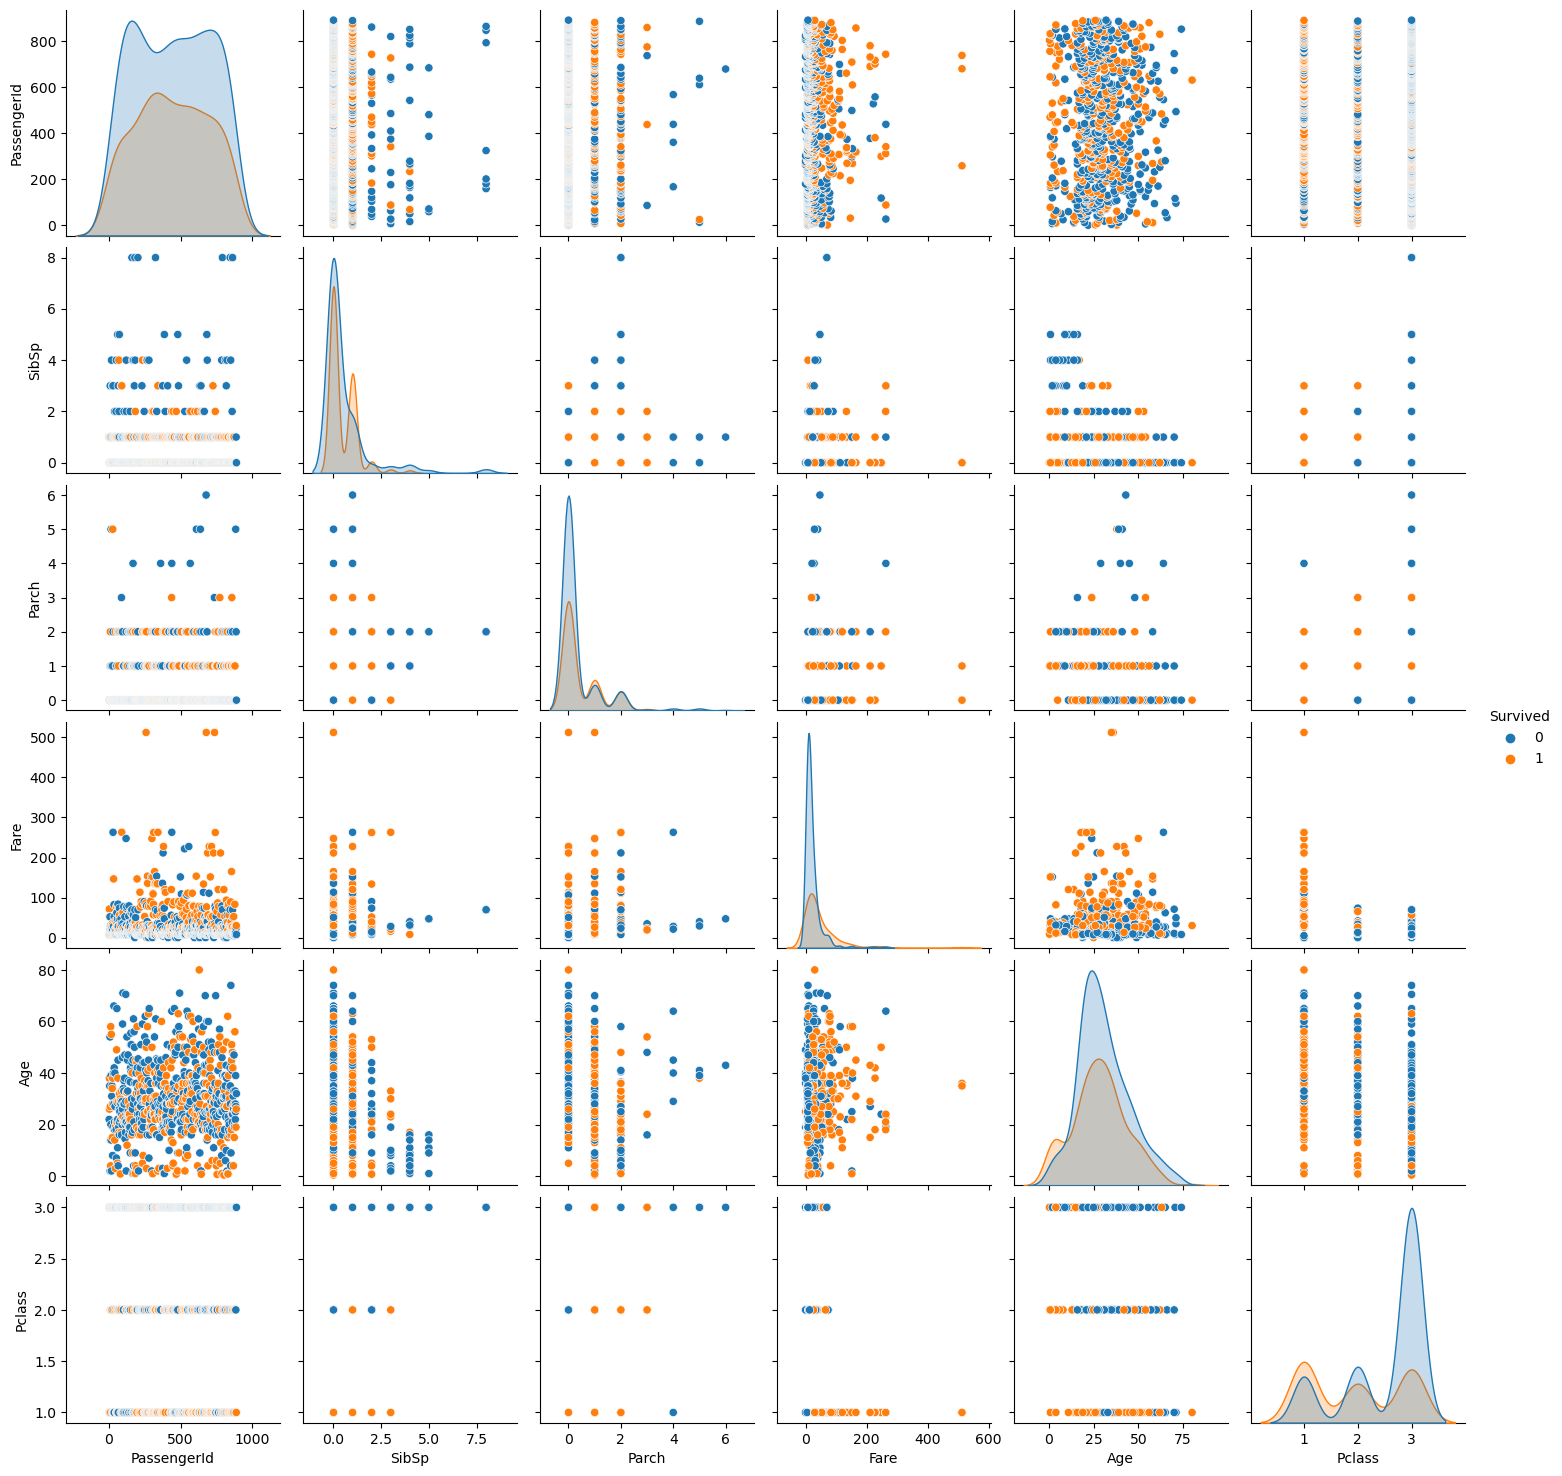

In [59]:
sns.pairplot(df_train_1, hue = "Survived");

## Arrrange  to digit

In [60]:
for df in [df_train_1, df_test_1]:
    df['Age_bin']=np.nan
    for i in range(8,0,-1):
        df.loc[ df['Age'] <= i*10, 'Age_bin'] = i


In [61]:
print(df_train_1[['Age' , 'Age_bin']].head(5))

    Age  Age_bin
0  22.0      3.0
1  38.0      4.0
2  26.0      3.0
3  35.0      4.0
4  35.0      4.0


In [62]:
for df in [df_train_1, df_test_1]:
    df['Fare_bin']=np.nan
    for i in range(12,0,-1):
        df.loc[ df['Fare'] <= i*50, 'Fare_bin'] = i

In [63]:
print(df_train_1[['Fare' , 'Fare_bin']].head(5))

      Fare  Fare_bin
0   7.2500       1.0
1  71.2833       2.0
2   7.9250       1.0
3  53.1000       2.0
4   8.0500       1.0


###   Data set copy for  model

In [64]:
df_train_ml = df_train_1.copy()
df_test_ml = df_test_1.copy()

### Get_dummies for categorical features

In [ ]:
#df_gender_sub_ml = pd.get_dummies(df_gender_sub_ml, columns=['Survived'], drop_first=True)
#df_train_ml.drop(['PassengerId','Name','Ticket', 'Cabin', 'Age_bin', 'Fare_bin'],axis=1,inplace=True)


In [65]:
df_train_ml = pd.get_dummies(df_train_ml, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)
df_train_ml.drop(['PassengerId','Name','Ticket', 'Cabin', 'Age_bin', 'Fare_bin'],axis=1,inplace=True)
df_train_ml.dropna(inplace=True)

In [66]:
passenger_id = df_test_ml['PassengerId']
df_test_ml = pd.get_dummies(df_test_1, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)
df_test_ml.drop(['PassengerId','Name','Ticket', 'Cabin', 'Age_bin', 'Fare_bin'],axis=1,inplace=True)


In [67]:
df_train_ml.head()

,SibSp,Parch,Fare,Age,Survived,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,1,0,7.2500,22.0,0,1,0,1,0,1
1,1,0,71.2833,38.0,1,0,0,0,0,0
2,0,0,7.9250,26.0,1,0,0,1,0,1
3,1,0,53.1000,35.0,1,0,0,1,0,0
4,0,0,8.0500,35.0,0,1,0,1,0,1


In [68]:
df_train_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SibSp       714 non-null    int64  
 1   Parch       714 non-null    int64  
 2   Fare        714 non-null    float64
 3   Age         714 non-null    float64
 4   Survived    714 non-null    int64  
 5   Sex_male    714 non-null    uint8  
 6   Embarked_Q  714 non-null    uint8  
 7   Embarked_S  714 non-null    uint8  
 8   Pclass_2    714 non-null    uint8  
 9   Pclass_3    714 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 37.0 KB


In [69]:
df_test_ml.head()

,SibSp,Parch,Fare,Age,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,0,7.8292,34.5,1,1,0,0,1
1,1,0,7.0000,47.0,0,0,1,0,1
2,0,0,9.6875,62.0,1,1,0,1,0
3,0,0,8.6625,27.0,1,0,1,0,1
4,1,1,12.2875,22.0,0,0,1,0,1


In [70]:
df_test_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SibSp       418 non-null    int64  
 1   Parch       418 non-null    int64  
 2   Fare        417 non-null    float64
 3   Age         332 non-null    float64
 4   Sex_male    418 non-null    uint8  
 5   Embarked_Q  418 non-null    uint8  
 6   Embarked_S  418 non-null    uint8  
 7   Pclass_2    418 non-null    uint8  
 8   Pclass_3    418 non-null    uint8  
dtypes: float64(2), int64(2), uint8(5)
memory usage: 15.2 KB


### Corelation 

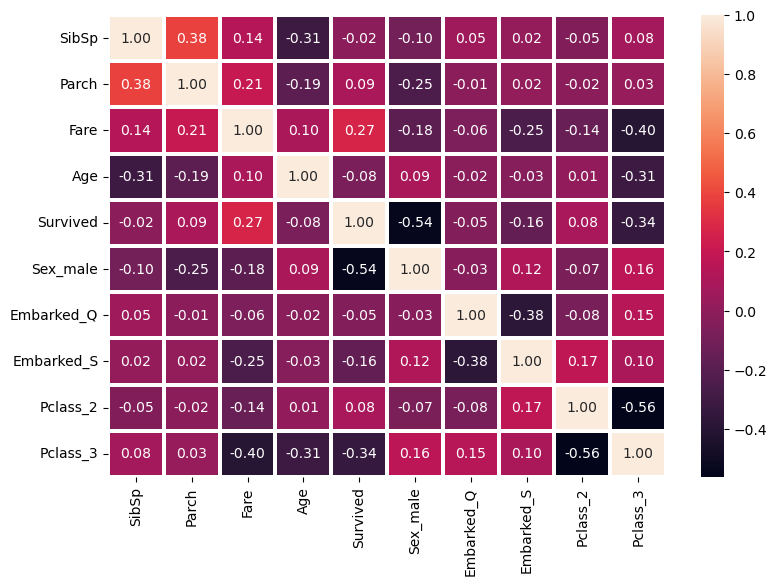

In [71]:
corr = df_train_ml.corr()

f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

In [72]:
df_train_ml.head(1)

,SibSp,Parch,Fare,Age,Survived,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,1,0,7.25,22.0,0,1,0,1,0,1


## Train | Test Split

In [73]:
X = df_train_ml[['SibSp', 'Parch', 'Fare','Age', 'Sex_male','Embarked_Q','Embarked_S','Pclass_2','Pclass_3']]
y = df_train_ml['Survived']

In [74]:
X.shape

(714, 9)

In [75]:
y.shape

(714,)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Performance

In [77]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

# AdaBoosting Classifier

In [78]:
ada_model = AdaBoostClassifier(n_estimators=50, random_state = 42)

In [79]:
ada_model.fit(X_train,y_train)

AdaBoostClassifier(random_state=42)

In [80]:
eval_metric(ada_model, X_train, y_train, X_test, y_test)

Test_Set
[[72 15]
 [17 39]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        87
           1       0.72      0.70      0.71        56

    accuracy                           0.78       143
   macro avg       0.77      0.76      0.76       143
weighted avg       0.78      0.78      0.78       143


Train_Set
[[299  38]
 [ 50 184]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       337
           1       0.83      0.79      0.81       234

    accuracy                           0.85       571
   macro avg       0.84      0.84      0.84       571
weighted avg       0.85      0.85      0.85       571



In [81]:
# overfit var mı yok mu  kesin anlamak  için

In [82]:
from sklearn.model_selection import cross_val_score, cross_validate

model = AdaBoostClassifier(n_estimators=50, random_state=42)

scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision", "recall", "f1"], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.795070
test_precision    0.756498
test_recall       0.739130
test_f1           0.743741
dtype: float64

In [83]:
from sklearn.tree import plot_tree

In [84]:
model = AdaBoostClassifier(n_estimators=50, random_state=42)
model.fit(X_train,y_train)

AdaBoostClassifier(random_state=42)

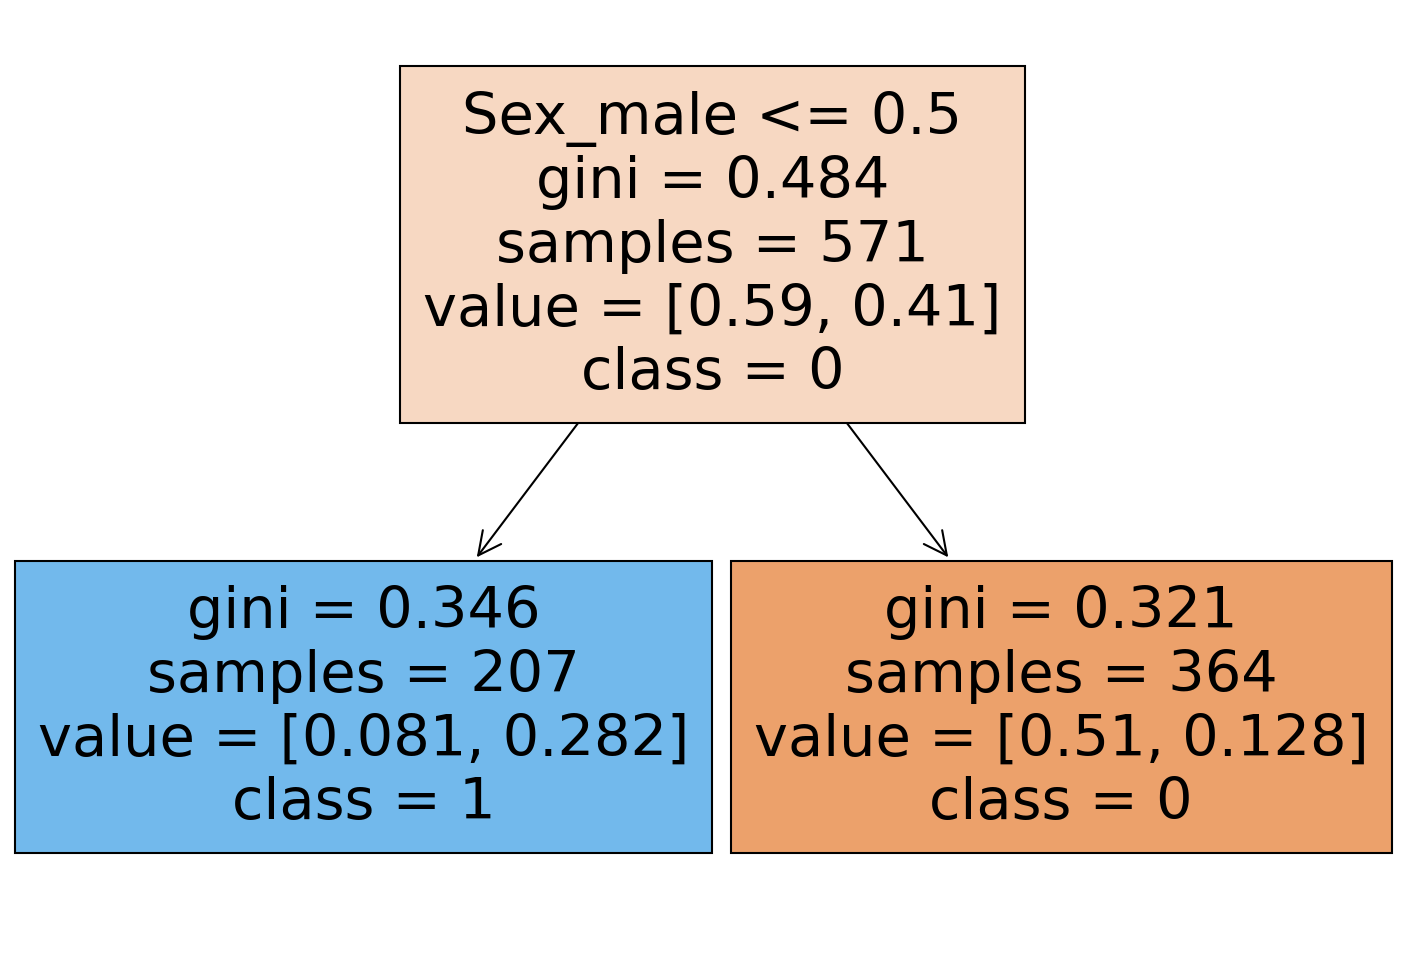

In [85]:
features = list(X.columns)
targets = df_train_ml["Survived"].astype("str") #boostingde mutlaka yap 
plt.figure(figsize=(12,8),dpi=150)
plot_tree(model.estimators_[0], filled=True, feature_names=X.columns, class_names=targets.unique());#proportion=True (oran için)

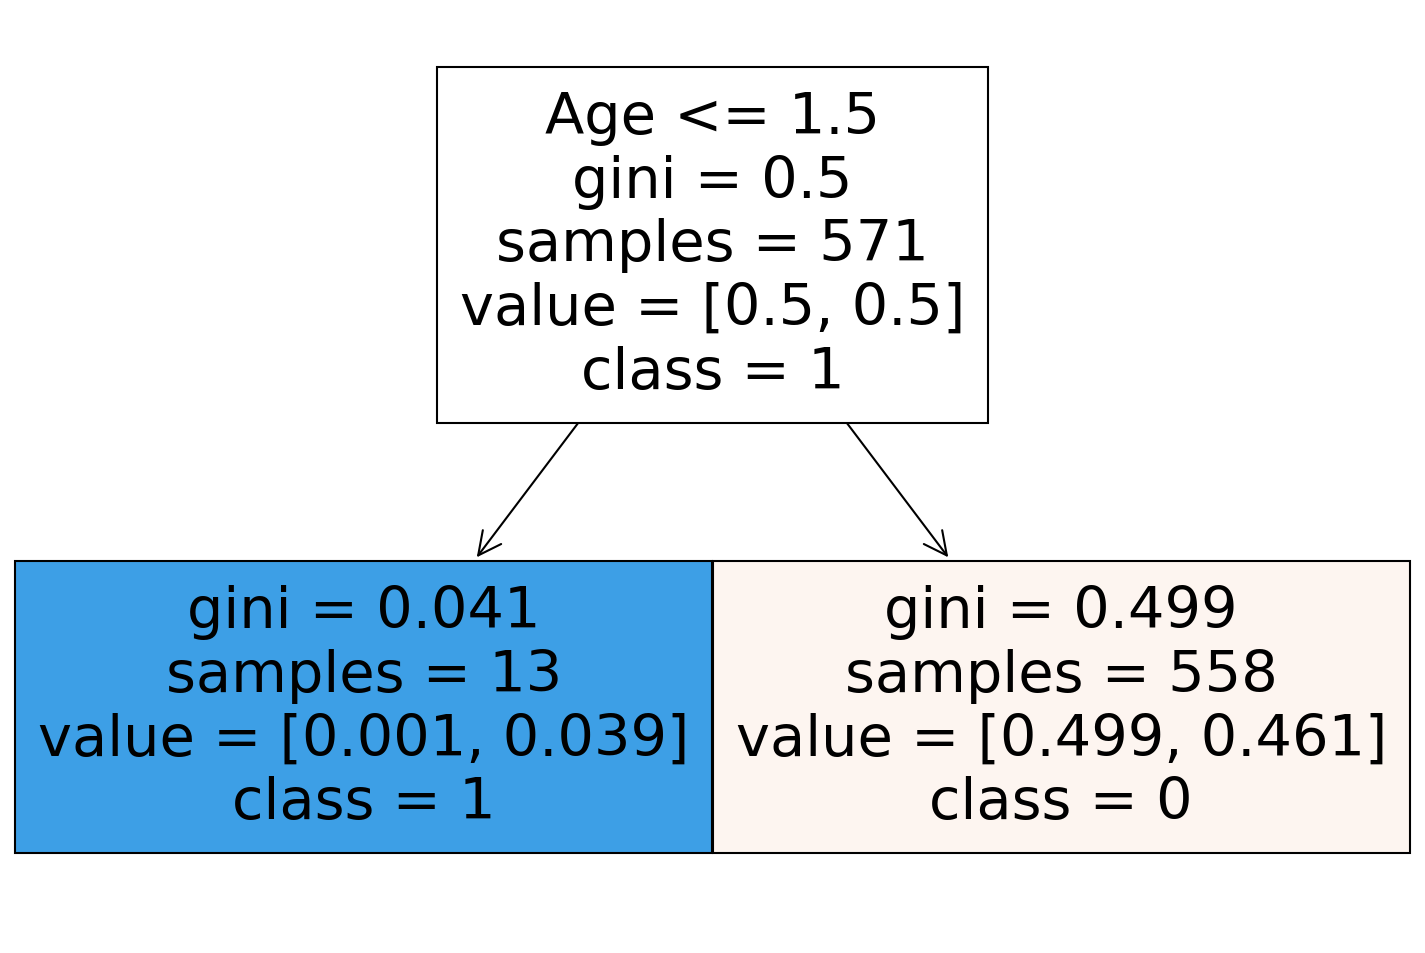

In [86]:
features = list(X.columns)
targets = df_train_ml["Survived"].astype("str") #boostingde mutlaka yap 
plt.figure(figsize=(12,8),dpi=150)
plot_tree(model.estimators_[2], filled=True, feature_names=X.columns, class_names=targets.unique());#proportion=True (oran için)

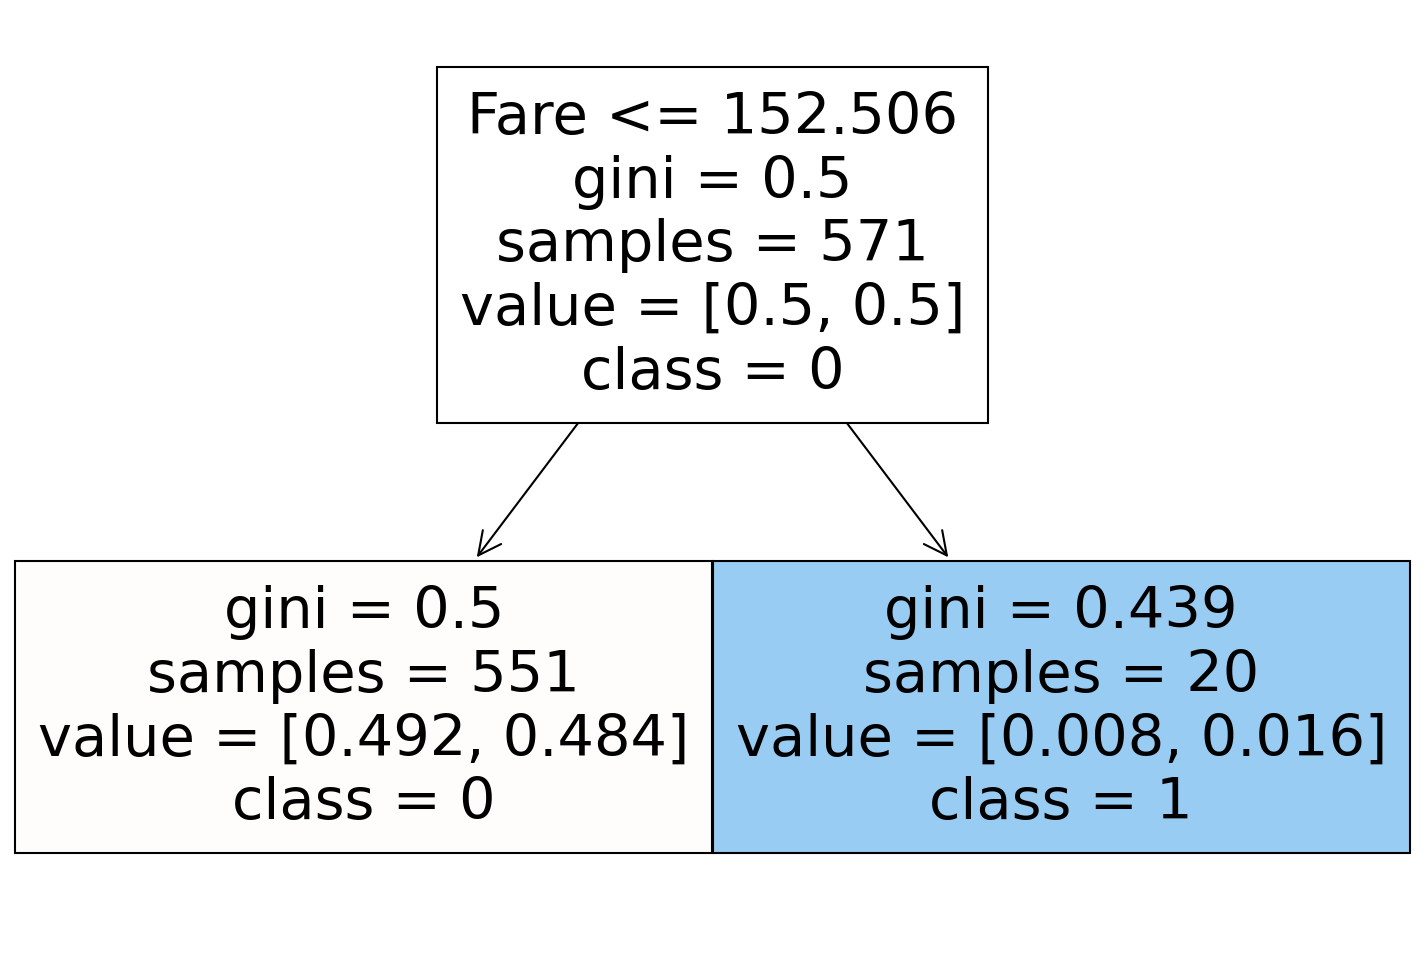

In [87]:
features = list(X.columns)
targets = df_train_ml["Survived"].astype("str") #boostingde mutlaka yap 
plt.figure(figsize=(12,8),dpi=150)
plot_tree(model.estimators_[49], filled=True, feature_names=X.columns, class_names=targets.unique());#proportion=True (oran için)

## Analyzing performance as more weak learners are added

In [88]:
model.estimator_errors_ 
# ilk ağaçta  en az hata ile ayırmış, sonraki sallanmalarda   hata artmış

array([0.2084063 , 0.33687243, 0.462232  , 0.42036176, 0.42417059,
       0.434192  , 0.46728653, 0.45505062, 0.48346766, 0.47884648,
       0.47491409, 0.45211292, 0.46140318, 0.48382608, 0.46079512,
       0.4544721 , 0.49429654, 0.48693619, 0.49229617, 0.48247821,
       0.47954973, 0.48464382, 0.49469352, 0.4677367 , 0.47020158,
       0.49554003, 0.49569789, 0.48299637, 0.48851983, 0.47781625,
       0.4754327 , 0.47338059, 0.46634312, 0.46169037, 0.48945741,
       0.48597268, 0.48850301, 0.4886815 , 0.47267671, 0.47109152,
       0.47132938, 0.47547877, 0.48972874, 0.49751779, 0.49639156,
       0.49142383, 0.48845673, 0.48056434, 0.47925056, 0.49183513])

In [89]:
error_rates = []

for n in range(1,100):
    
    model = AdaBoostClassifier(n_estimators=n)
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    err = 1 - f1_score(y_test,preds)
    
    error_rates.append(err)

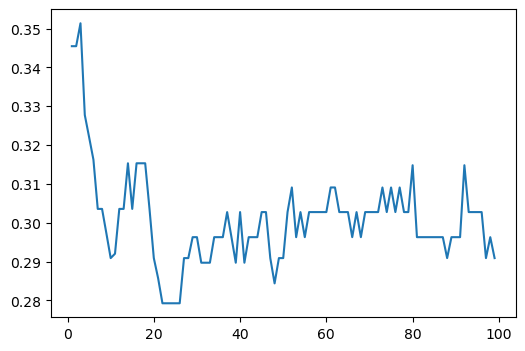

In [90]:
plt.plot(range(1,100), error_rates);

## Grid Search

In [91]:
from sklearn.model_selection import GridSearchCV

In [92]:
model = AdaBoostClassifier(random_state=42)

In [93]:
param_grid = {"n_estimators": [20, 30, 64, 100, 128, 200 ], "learning_rate": [0.01, 0.1, 0.2, 0.5, 1.0]}

In [94]:
ada_grid_model = GridSearchCV(model, param_grid, cv = 5, scoring = "f1")

In [95]:
ada_grid_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
                         'n_estimators': [20, 30, 64, 100, 128, 200]},
             scoring='f1')

In [96]:
ada_grid_model.best_params_

{'learning_rate': 1.0, 'n_estimators': 128}

In [97]:
ada_grid_model.best_score_ # burada  f1  skorunu  aldık

0.771039796031482

In [98]:
y_pred = ada_grid_model.predict(X_test)

ada_f1 = f1_score(y_test, y_pred)
ada_recall = recall_score(y_test, y_pred)
ada_auc = roc_auc_score(y_test, y_pred)
eval_metric(ada_grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[71 16]
 [19 37]]
              precision    recall  f1-score   support

           0       0.79      0.82      0.80        87
           1       0.70      0.66      0.68        56

    accuracy                           0.76       143
   macro avg       0.74      0.74      0.74       143
weighted avg       0.75      0.76      0.75       143


Train_Set
[[303  34]
 [ 44 190]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       337
           1       0.85      0.81      0.83       234

    accuracy                           0.86       571
   macro avg       0.86      0.86      0.86       571
weighted avg       0.86      0.86      0.86       571



## Feature Importances

In [99]:
model = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
model.feature_importances_

feats = pd.DataFrame(index=X.columns, data= model.feature_importances_, columns=['ada_importance'])
ada_imp_feats = feats.sort_values("ada_importance")
ada_imp_feats

,ada_importance
Embarked_Q,0.00
Pclass_2,0.00
Embarked_S,0.03
Parch,0.07
Pclass_3,0.09
SibSp,0.10
Fare,0.17
Sex_male,0.25
Age,0.29


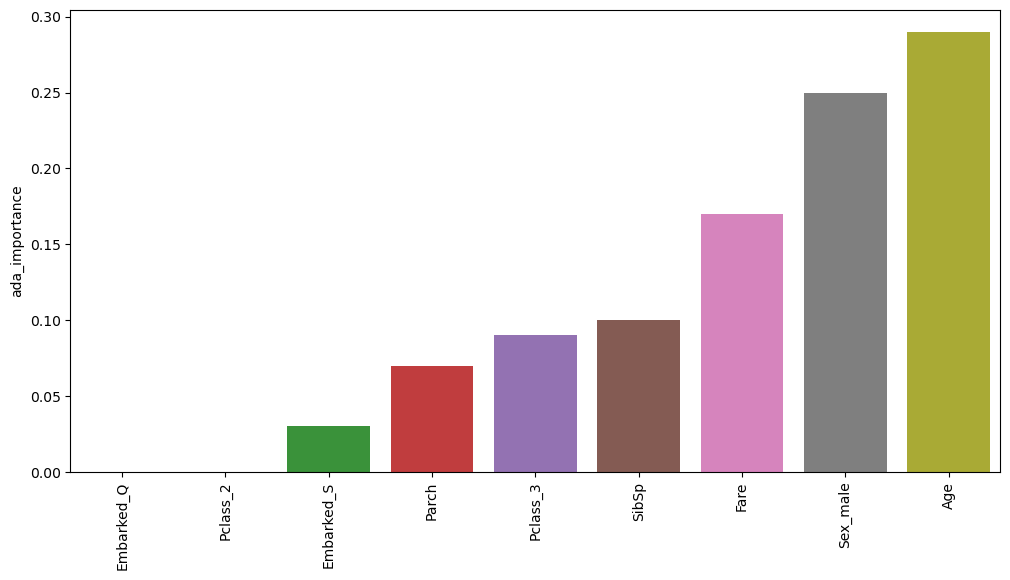

In [100]:
plt.figure(figsize=(12,6))
sns.barplot(data=ada_imp_feats ,x=ada_imp_feats.index, y='ada_importance')

plt.xticks(rotation=90);

## Evaluating ROC Curves and AUC

In [101]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score

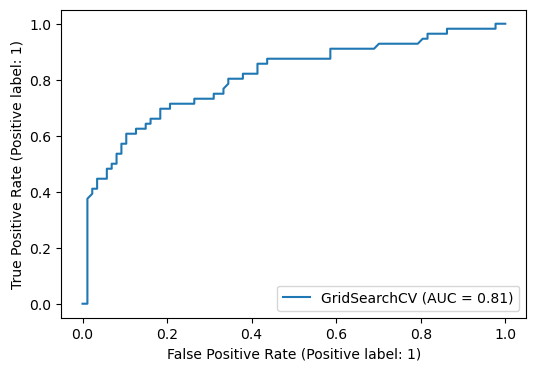

In [102]:
plot_roc_curve(ada_grid_model, X_test, y_test);

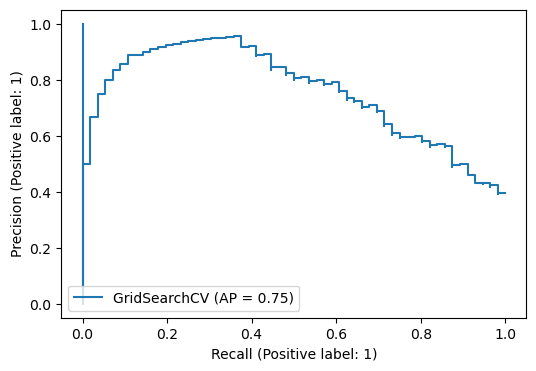

In [103]:
plot_precision_recall_curve(ada_grid_model, X_test, y_test);

# GradientBoosting Classifier

In [104]:
from sklearn.ensemble import GradientBoostingClassifier

In [105]:
grad_model = GradientBoostingClassifier(random_state=42)

In [106]:
grad_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [107]:
eval_metric(grad_model, X_train, y_train, X_test, y_test)

Test_Set
[[77 10]
 [18 38]]
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        87
           1       0.79      0.68      0.73        56

    accuracy                           0.80       143
   macro avg       0.80      0.78      0.79       143
weighted avg       0.80      0.80      0.80       143


Train_Set
[[327  10]
 [ 39 195]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       337
           1       0.95      0.83      0.89       234

    accuracy                           0.91       571
   macro avg       0.92      0.90      0.91       571
weighted avg       0.92      0.91      0.91       571



In [108]:
model = GradientBoostingClassifier(random_state=42)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1', 'roc_auc'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.833666
test_precision    0.838547
test_recall       0.739493
test_f1           0.781657
test_roc_auc      0.862636
dtype: float64

###  Gridsearch

In [109]:
param_grid = {"n_estimators":[20, 30, 64, 100, 128, 200],
             "subsample":[0.5, 1], "max_features" : [None, 2, 3, 4]}, #"learning_rate": [0.001, 0.01, 0.1], 'max_depth':[3,4,5,6]

In [110]:
gb_model = GradientBoostingClassifier(random_state=42)

In [111]:
grid = GridSearchCV(gb_model, param_grid, scoring = "f1", verbose = 2, n_jobs= -1).fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [112]:
grid.best_params_

{'max_features': 3, 'n_estimators': 100, 'subsample': 1}

In [113]:
grid.best_score_

0.7978142712316458

In [114]:
y_pred = grid.predict(X_test)

gb_f1 = f1_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)
gb_auc = roc_auc_score(y_test, y_pred)

eval_metric(grid, X_train, y_train, X_test, y_test)

Test_Set
[[75 12]
 [15 41]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        87
           1       0.77      0.73      0.75        56

    accuracy                           0.81       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.81      0.81      0.81       143


Train_Set
[[316  21]
 [ 38 196]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       337
           1       0.90      0.84      0.87       234

    accuracy                           0.90       571
   macro avg       0.90      0.89      0.89       571
weighted avg       0.90      0.90      0.90       571



### Fetaure Importance

In [115]:
model = GradientBoostingClassifier(max_features= 3, n_estimators = 100, subsample = 0.5, random_state=42)
model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(index=X.columns, data=model.feature_importances_, columns=['grad_importance'])
grad_imp_feats = feats.sort_values("grad_importance")
grad_imp_feats

,grad_importance
Embarked_Q,0.009130
Pclass_2,0.019859
Embarked_S,0.021812
Parch,0.053460
SibSp,0.055833
Pclass_3,0.089534
Age,0.213710
Fare,0.239772
Sex_male,0.296890


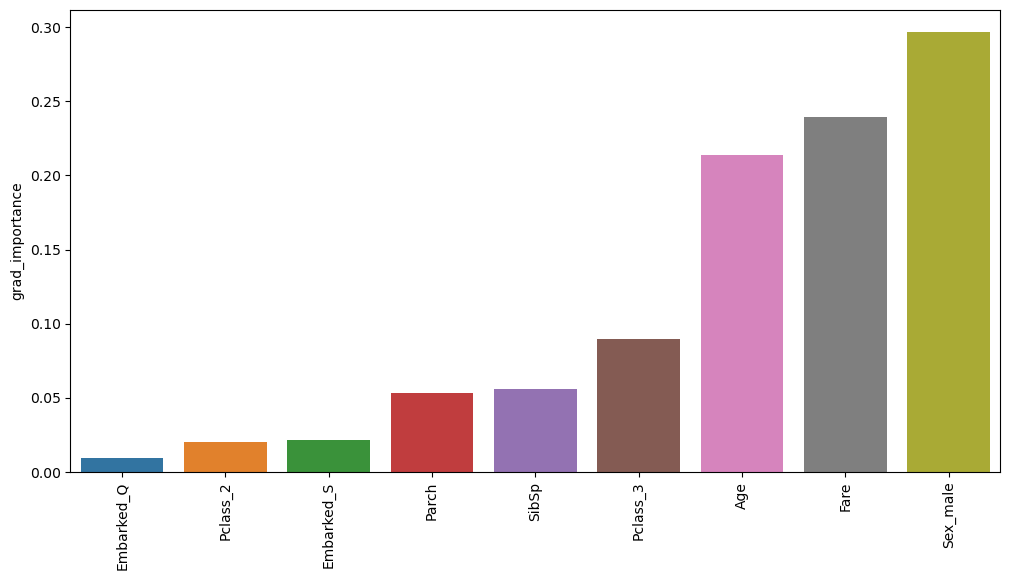

In [116]:
plt.figure(figsize=(12,6))
sns.barplot(data=grad_imp_feats, x=grad_imp_feats.index, y='grad_importance')

plt.xticks(rotation=90);

### Evaluating ROC Curves and AUC¶

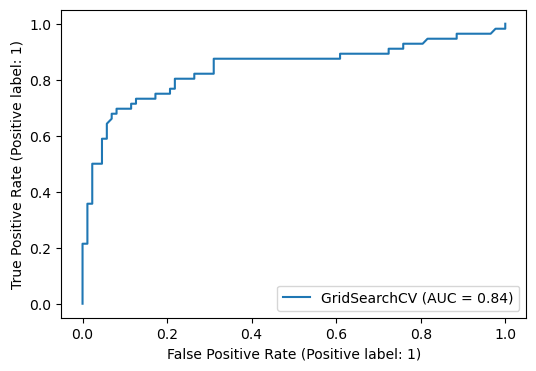

In [117]:
plot_roc_curve(grid, X_test, y_test);

# XGBoosting Classifier

In [118]:
from xgboost import XGBClassifier

In [119]:
xgb = XGBClassifier(random_state = 42).fit(X_train, y_train)

In [120]:
eval_metric(xgb, X_train, y_train, X_test, y_test)

Test_Set
[[73 14]
 [17 39]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.82        87
           1       0.74      0.70      0.72        56

    accuracy                           0.78       143
   macro avg       0.77      0.77      0.77       143
weighted avg       0.78      0.78      0.78       143


Train_Set
[[336   1]
 [  9 225]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       337
           1       1.00      0.96      0.98       234

    accuracy                           0.98       571
   macro avg       0.98      0.98      0.98       571
weighted avg       0.98      0.98      0.98       571



In [121]:
model = XGBClassifier(random_state=42)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1', 'roc_auc'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy     0.802117
test_precision    0.769734
test_recall       0.752174
test_f1           0.755191
test_roc_auc      0.862366
dtype: float64

## Gridsearch

In [122]:
param_grid = {"n_estimators":[20, 30, 64, 100, 128, 200],'max_depth':[3,4,5], "learning_rate": [0.1, 0.2],
             "subsample":[0.5, 0.8, 1], "colsample_bytree":[0.5,0.7, 1]}

In [123]:
xgb_model = XGBClassifier(random_state=42)

In [124]:
xgb_grid = GridSearchCV(xgb_model, param_grid, scoring = "f1", verbose=2, n_jobs = -1).fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [125]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 5,
 'n_estimators': 30,
 'subsample': 0.8}

In [126]:
xgb_grid.best_score_

0.8002729966185738

In [127]:
y_pred = xgb_grid.predict(X_test)

xgb_f1 = f1_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred)

eval_metric(xgb_grid, X_train, y_train, X_test, y_test)

Test_Set
[[74 13]
 [15 41]]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        87
           1       0.76      0.73      0.75        56

    accuracy                           0.80       143
   macro avg       0.80      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143


Train_Set
[[322  15]
 [ 40 194]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       337
           1       0.93      0.83      0.88       234

    accuracy                           0.90       571
   macro avg       0.91      0.89      0.90       571
weighted avg       0.91      0.90      0.90       571



## Feature importances

In [128]:
model = XGBClassifier(random_state=42, colsample_bytree = 0.5, subsample= 0.8)
model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(index=X.columns, data=model.feature_importances_, columns=['xgb_importance'])
xgb_imp_feats = feats.sort_values("xgb_importance")
xgb_imp_feats

,xgb_importance
Embarked_S,0.027571
Embarked_Q,0.028533
SibSp,0.032111
Pclass_2,0.036623
Parch,0.039923
Fare,0.054120
Age,0.056268
Pclass_3,0.107090
Sex_male,0.617761


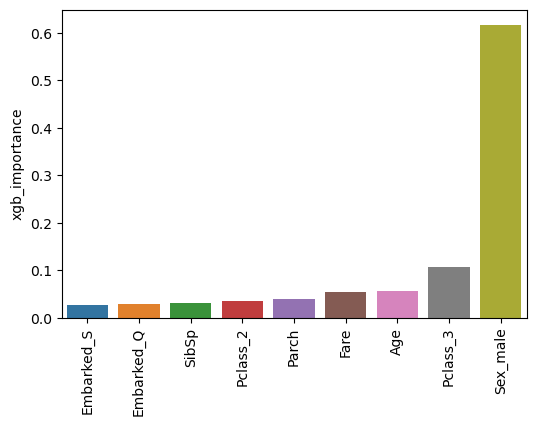

In [129]:
sns.barplot(data=xgb_imp_feats, x=xgb_imp_feats.index,y='xgb_importance')

plt.xticks(rotation=90);

## Feature importance comparison

In [130]:
pd.concat([ada_imp_feats, grad_imp_feats, xgb_imp_feats], axis=1)

,ada_importance,grad_importance,xgb_importance
Embarked_Q,0.00,0.009130,0.028533
Pclass_2,0.00,0.019859,0.036623
Embarked_S,0.03,0.021812,0.027571
Parch,0.07,0.053460,0.039923
Pclass_3,0.09,0.089534,0.107090
SibSp,0.10,0.055833,0.032111
Fare,0.17,0.239772,0.054120
Sex_male,0.25,0.296890,0.617761
Age,0.29,0.213710,0.056268


## Evaluating ROC Curves and AUC

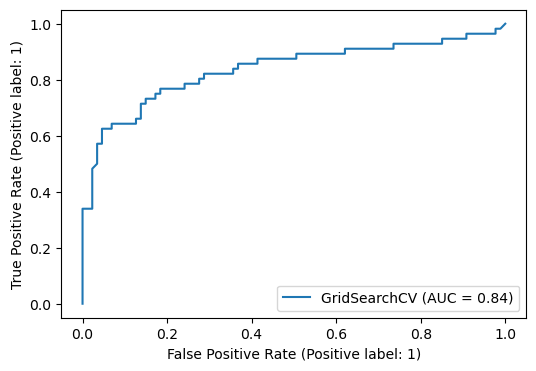

In [131]:
plot_roc_curve(xgb_grid, X_test, y_test);

## Comparing Models

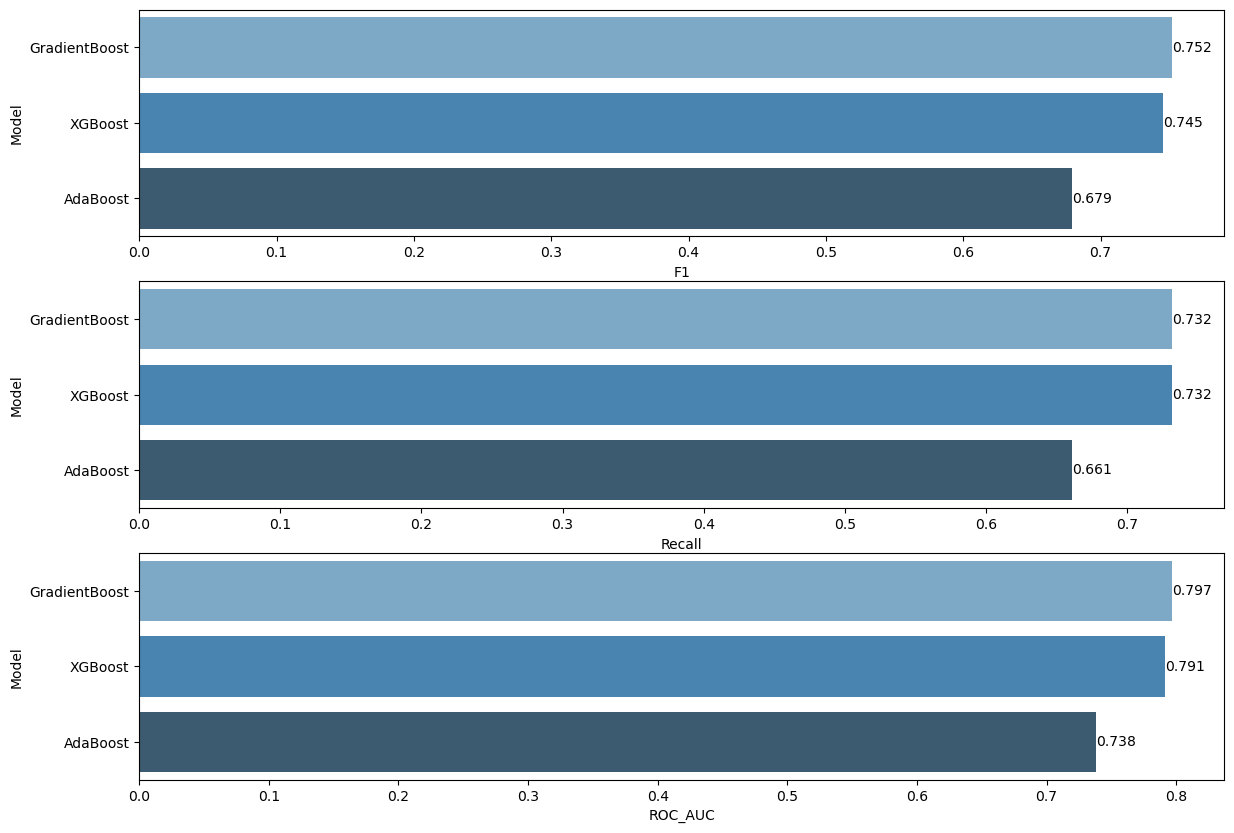

In [132]:
compare = pd.DataFrame({"Model": [ "AdaBoost","GradientBoost", "XGBoost"],
                        "F1": [ ada_f1, gb_f1, xgb_f1],
                        "Recall": [ada_recall, gb_recall, xgb_recall],
                        "ROC_AUC": [ ada_auc, gb_auc, xgb_auc]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(14,10))
plt.subplot(311)
compare = compare.sort_values(by="F1", ascending=False)
ax=sns.barplot(x="F1", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(312)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(313)
compare = compare.sort_values(by="ROC_AUC", ascending=False)
ax=sns.barplot(x="ROC_AUC", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show()

## Conclusion

## Gender  Submission 

In [150]:
df_test_ml.head(1)

,SibSp,Parch,Fare,Age,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,0,0,7.8292,34.5,1,1,0,0,1


In [149]:
df_gender_sub.head(1)

,PassengerId,Survived
0,892,0


In [147]:
sub_pred = xgb_grid.predict(df_test_ml)
f1_score(df_gender_sub.Survived.values, sub_pred)

0.7528089887640449

In [148]:
y_pred = xgb_grid.predict(df_test_ml)

xgb_f1 = f1_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred)

eval_metric(xgb_grid, X_train, y_train, X_test, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [143, 418]

In [ ]:
eval_metric(xgb, X_train, y_train, X_test, y_test)